## Certificate Transparency

### Import libraries

In [1]:
import os
import pandas as pd 
import numpy as np
from lxml import etree 
pd.set_option('display.max_columns', None)
pd.options.display.max_colwidth = 200
import os
import glob
import time
import re
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import matplotlib.patches as mpatches
import shutil
from IPython.display import clear_output
pd.set_option('display.max_rows', 500)
from manuf import manuf
from user_agents import parse
import dataframe_image as dfi
import tldextract
import random

### Readin dataset: with crt.sh query results

In [2]:
df = pd.read_parquet("../datasets/ny_serv_withcrt.parquet")

### Process

In [3]:
df['cert_days'] = df['cert_validity_days'].apply(lambda x: int(x.split(" ")[0]))

In [4]:
names = pd.read_parquet("../datasets/sni_used_to_generate_pcaps.parquet")

In [5]:
df = pd.merge(df, names, how='left', left_on='server_name_indication', right_on='sni')

In [6]:
df.shape

(371079, 124)

In [7]:
df.loc[df['device_id'].isna()].shape

(0, 124)

In [8]:
df.groupby(['serial_num', 'sni', 'issuer_CN', 'device_vendor'])['cert_id'].agg('count').reset_index(name='count').shape

(4949, 5)

### Leaf certificate validity days

### Drop columns that will not be used in the analysis

In [9]:
_col2drop = ['cert_keyIdentifier', 'cert_sortedtime', 'cert_subjectKeyIdentifier', 'cert_mapped_idx', \
             'cert_cap_ts', 'cert_cap_uts', 'dev_dst_ip_x', 'dev_dst_port_x', 'dev_dst_sni', 'cert_idx_list', \
             'client_ciphersuite_code', 'client_compression_method', 'client_extension_type_code', 'client_hello_id', \
             'client_idx', 'client_sig_hash_alg_code', 'client_sig_hash_hash_code', 'client_supported_group_code', \
             'clnt_mapped_idx', 'clnt_cap_ts', 'clnt_cap_uts', 'clnt_ip_dst', 'clnt_ip_src', 'clnt_tcp_dstport', \
             'clnt_tcp_srcport', 'clnt_ts_idx_end', 'clnt_ts_idx_start', 'client_tls_version', 'client_ciphersuite', \
             'client_extension_type', 'client_supported_groups', 'client_sig_hash_alg', 'client_sig_hash_hash', \
             'if_weak_cipher_included', 'weak_cipher_included', 'weak_sigalg_included', 'dev_dst_ip_y', 'dev_dst_port_y', \
             'cert_ts_idx_end', 'cert_ts_idx_start', 'server_hello_id', 'server_idx', 'serv_mapped_idx', 'serv_cap_ts', \
             'serv_cap_uts', 'serv_ip_dst', 'serv_ip_src', 'serv_tcp_dstport', 'serv_tcp_srcport', 'serv_ts_idx_end', \
             'serv_ts_idx_start', 'dev_dst_ip', 'dev_dst_port']

In [10]:
dev_dropcol = df.drop([*_col2drop], 1)

In [11]:
dev_dropcol.sample(1)

,cert_alg_element,cert_basicConstraints_cA,cert_id,cert_idx,cert_ifCRLSign,cert_ifDataEncipherment,cert_ifDigitalSig,cert_ifKeyCertSign,cert_ifKeyEncipherment,cert_issuer,cert_public_key_exponent,cert_resourceIdentifier,cert_san,cert_sct_logid,cert_serialNum_from_ber,cert_serialNum_from_x509af,cert_sig_hash_hash,cert_sig_hash_sig,cert_sig_len,cert_subject,cert_version,serv_curve,cert_notBefore,cert_notAfter,cert_validity_days,cert_ip_dst,cert_ip_src,cert_tcp_dstport,cert_tcp_srcport,issuer_CN,issuer_O,issuer_OUnit,issuer_C,subject_CN,subject_O,subject_OUnit,subject_C,cert_sig_alg,if_weak_sig_alg,cert_loc,cert_chain_len,chain_issuer,chain_issuer_O,chain_issuer_CN,chain_subject,chain_subject_O,chain_subject_CN,chain_basicConstraintsCA,chain_ifKeyCertSign,chain_keyIdentifier,chain_subjectIdentifier,chain_serial_from_ber,chain_serial_from_x509af,server_name_indication,if_tls_fallback,if_weak_sigalg,server_ciphersuite,server_ciphersuite_code,server_compression_method,server_extension_type_code,server_tls_version,server_extension_type,if_weak_cipher,serial_num,response,cert_days,device_id,sni,device_vendor,device_name,user_key
306522,id-ecPublicKey,NaN,1.0,155.0,NaN,NaN,NaN,NaN,NaN,"rdnSequence: 3 items (id-at-commonName=GTS CA 1C3,id-at-organizationName=Google Trust Services LLC,id-at-countryName=US)",NaN,http://ocsp.pki.goog/gts1c3,"*.google.com,*.appengine.google.com,*.bdn.dev,*.cloud.google.com,*.crowdsource.google.com,*.datacompute.google.com,*.google.ca,*.google.cl,*.google.co.in,*.google.co.jp,*.google.co.uk,*.google.com...",41c8cab1df22464a10c6a13a0942875e4e318b1b03ebeb4bc768f090629606f6,NaN,5fec2188d7658a640a000000013c6752,SHA256,ECDSA,NaN,rdnSequence: 1 item (id-at-commonName=*.google.com),v3,None,2022-03-28 01:19:44,2022-06-20 01:19:43,83 days 23:59:59,67.205.150.252,142.251.40.110,56837,443,GTS CA 1C3,Google Trust Services LLC,NaN,US,*.google.com,nan,NaN,None,sha256WithRSAEncryption,False,0,3,"[rdnSequence: 3 items (id-at-commonName=GTS CA 1C3,id-at-organizationName=Google Trust Services LLC,id-at-countryName=US), rdnSequence: 3 items (id-at-commonName=GTS Root R1,id-at-organizationName...","[Google Trust Services LLC, Google Trust Services LLC, GlobalSign nv-sa]","[GTS CA 1C3, GTS Root R1, GlobalSign Root CA]","[rdnSequence: 1 item (id-at-commonName=*.google.com), rdnSequence: 3 items (id-at-commonName=GTS CA 1C3,id-at-organizationName=Google Trust Services LLC,id-at-countryName=US), rdnSequence: 3 items...","[nan, Google Trust Services LLC, Google Trust Services LLC]","[*.google.com, GTS CA 1C3, GTS Root R1]","[nan, 1.0, 1.0]","[None, None, None]","[8a747faf85cdee95cd3d9cd0e24614f371351d27, e4af2b26711a2b4827852f52662ceff08913713e, 607b661a450d97ca89502f7d04cd34a8fffcfd4b]","[8c8f051c21aede03586ca1941746a77bf7c295c2, 8a747faf85cdee95cd3d9cd0e24614f371351d27, e4af2b26711a2b4827852f52662ceff08913713e]","[None, None, None]","[5fec2188d7658a640a000000013c6752, 0203bc53596b34c718f5015066, 77bd0d6cdb36f91aea210fc4f058d30d]",play.google.com,False,False,TLS_ECDHE_ECDSA_WITH_CHACHA20_POLY1305_SHA256,cca9,['0'],"['23', '65281', '11', '35']",TLS 1.2,"['extended_master_secret', 'renegotiation_info', 'ec_point_formats', 'session_ticket']",False,5fec2188d7658a640a000000013c6752,True,83,s1706564edf,play.google.com,google,google-home,4rktr9y69jdpEsTi


In [12]:
dev_dropcol['device_vendor'] = dev_dropcol['device_vendor'].fillna("missing")

In [13]:
df_leafval = dev_dropcol.loc[dev_dropcol['device_vendor'] != 'missing']\
                            [['device_vendor', 'sni', 'serial_num', 'response', \
                              'cert_days', 'issuer_O', 'issuer_CN', 'device_id']]

In [14]:
df_leafval_drop = df_leafval.drop_duplicates()

In [15]:
df_leafval_drop.shape

(24480, 8)

In [16]:
df_leafval_temp = df_leafval_drop.groupby(['device_vendor'])['sni'].agg('count').reset_index(name='count')

In [17]:
df_leafval_merge = df_leafval_drop.merge(df_leafval_temp, how='inner', on='device_vendor')

In [18]:
df_leafval_sort = df_leafval_merge.sort_values(by='count', ascending=False)

### Get log10 based validity

In [19]:
df_leafval_sort['certday_log10'] = df_leafval_sort['cert_days'].apply(lambda x: np.log10(x))

In [20]:
df_leafval_sort.shape

(24480, 10)

### Common & dev-spec issuer

In [21]:
pub_lis = ["DigiCert", "Let's Encrypt", "GoDaddy.com", "Sectigo", "GlobalSign nv-sa", "Network Solutions", \
           "Cloudflare", "Entrust", "COMODO CA", "Gandi", "Yandex", "ZeroSSL", "Trustwave Holdings", \
           "GEANT Vereniging", "SSL Corporation", "HydrantID Avalanche Cloud Corporation", \
           "Microsoft Corporation", "Apple", "Google Trust Services", "Amazon", "Starfield Technologies", \
           "Entrust", "TAIWAN-CA", "cPanel", "COMODO", "Comodo Japan", "Symantec", "Symantec Corporation"]

In [22]:
df_leafval_sort['issuer_O'] = df_leafval_sort['issuer_O'].fillna("missing")

In [23]:
def parse_issuer(text):
    if text.startswith('mediasoup'):
        return "mediasoup"
    return text.replace('\\', '').replace('\"', '')\
               .split(" Inc")[0].split(" INC")[0].split(" L.L.C.")[0].split(" LLC")[0].split(" llc")[0].split(" Hue")[0]\
               .split(" Co.")[0].split(" CO.")[0].split(" Ltd")[0].split(" Limited")[0].split(" GmbH")[0].split(" inc")[0].split(" CA")[0]

In [24]:
df_leafval_sort['issuer_O'] = df_leafval_sort['issuer_O'].apply(lambda x: parse_issuer(x))

In [25]:
df_leafval_sort['issuer'] = df_leafval_sort['issuer_O'].apply(lambda x: "Public trust" if x in pub_lis else "Untrust")

In [26]:
df_leafval_sort['issuer'].value_counts().nlargest(4)

Public trust    21016
Untrust          3464
Name: issuer, dtype: int64

### Rename

In [28]:
df_leafval_sort['device_vendor'] = df_leafval_sort['device_vendor'].apply(lambda x: x.capitalize())

In [29]:
df_leafval_sort.device_vendor[df_leafval_sort['device_vendor'].str.contains('Lg')] = 'LG'
df_leafval_sort.device_vendor[df_leafval_sort['device_vendor'].str.contains('Directv')] = 'DirecTV'
df_leafval_sort.device_vendor[df_leafval_sort['device_vendor'].str.contains('Dish network')] = 'Dish Network'
df_leafval_sort.device_vendor[df_leafval_sort['device_vendor'].str.contains('Tcl')] = 'TCL'
df_leafval_sort.device_vendor[df_leafval_sort['device_vendor'].str.contains('Tplink')] = 'TP-Link'
df_leafval_sort.device_vendor[df_leafval_sort['device_vendor'].str.contains('Western digital')] = 'Western Digital'
df_leafval_sort.device_vendor[df_leafval_sort['device_vendor'].str.contains('Hp')] = 'HP'
df_leafval_sort.device_vendor[df_leafval_sort['device_vendor'].str.contains('Ihome')] = 'iHome'
df_leafval_sort.device_vendor[df_leafval_sort['device_vendor'].str.contains('Ikea')] = 'IKEA'
df_leafval_sort.device_vendor[df_leafval_sort['device_vendor'].str.contains('Irobot')] = 'iRobot'
df_leafval_sort.device_vendor[df_leafval_sort['device_vendor'].str.contains('Netgear')] = 'NETGEAR'
df_leafval_sort.device_vendor[df_leafval_sort['device_vendor'].str.contains('Qnap')] = 'QNAP'
df_leafval_sort.device_vendor[df_leafval_sort['device_vendor'].str.contains('Sleep number')] = 'Sleep Number'
df_leafval_sort.device_vendor[df_leafval_sort['device_vendor'].str.contains('Echobee')] = 'echobee'
df_leafval_sort.device_vendor[df_leafval_sort['device_vendor'].str.contains('Idevices')] = 'iDevices'
df_leafval_sort.device_vendor[df_leafval_sort['device_vendor'].str.contains('Vmware')] = 'VMware'
df_leafval_sort.device_vendor[df_leafval_sort['device_vendor'].str.contains('Hdhomerun')] = 'HDHomeRun'
df_leafval_sort.device_vendor[df_leafval_sort['device_vendor'].str.contains('Ecobee')] = 'ecobee'
df_leafval_sort.device_vendor[df_leafval_sort['device_vendor'].str.contains('Texas instruments')] = 'Texas Instruments'

<ipython-input-29-52a4fb359ec2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_leafval_sort.device_vendor[df_leafval_sort['device_vendor'].str.contains('Lg')] = 'LG'
<ipython-input-29-52a4fb359ec2>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_leafval_sort.device_vendor[df_leafval_sort['device_vendor'].str.contains('Directv')] = 'DirecTV'
<ipython-input-29-52a4fb359ec2>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lea

### Drop records with unknown devices

In [31]:
df_leafval_sort = df_leafval_sort.loc[df_leafval_sort['device_vendor'] != "Unknown"]

### Plot

In [32]:
def jitter(x):
    return x + random.uniform(0, .5) - .25

In [33]:
vendor_ids = {'Amazon': 1, 'Samsung':2, 'Roku': 3, 'Google': 4, 'LG':5, \
            'Sony': 6, 'Nvidia': 7, 'Cisco': 8, 'Tivo': 9, 'Xiaomi': 10, \
            'HP': 11, 'Insignia': 12, 'TCL': 13, 'Wink': 14, 'Vizio': 15, \
            'Sharp': 16, 'Brother': 17, 'Synology': 18, 'Lutron': 19, 'Sonos': 20, \
            'Nintendo': 21, 'Amcrest': 22, 'TP-Link': 23, 'Panasonic': 24, 'Tesla': 25, \
            'Logitech': 26, 'Philips': 27, 'Netatmo': 28, 'Dish Network': 29, \
            'Sky': 30, 'QNAP': 31, 'Pioneer': 32, 'Onkyo': 33, \
            'iDevices': 34, 'NETGEAR': 35, 'Humax': 36, 'iRobot': 37, \
            'Wyze': 38, 'DirecTV': 39, 'Sense':40, \
             'Ubiquity':41, 'ecobee':42, 'Texas Instruments':43, 'Arlo':44, \
             'Denon':45, 'VMware':46, 'Canon':47, 'Epson':48,\
             'IKEA':49, 'Western Digital':50, 'Belkin':51, 'Bose':52, \
             'Silicondust':53, 'Withings': 54, 'HDHomeRun':55, 'Marantz':56, 'Canary':57, \
             'Vera':58, 'Yamaha':59, 'Tuya':60, 'Fing':61, 'Nanoleaf':62, \
             'Sleep Number':63, 'Obihai':64, 'Skybell':65}

df_leafval_sort['vendor_id'] = df_leafval_sort['device_vendor'].apply(lambda x: vendor_ids[x])
df_leafval_sort['jittered'] = df_leafval_sort['vendor_id'].apply(lambda x: jitter(x))

In [34]:
df_leafval_sort = df_leafval_sort.rename(columns={'response': 'In CT', 'issuer': 'Issuer'})

In [35]:
df_leafval_sort['In CT'].value_counts().nlargest()

True     20981
False     3496
Name: In CT, dtype: int64

In [36]:
df_leafval_sort.loc[(df_leafval_sort['In CT'] == True) &\
                    (df_leafval_sort['Issuer'] == 'Untrust')]

,device_vendor,sni,serial_num,In CT,cert_days,issuer_O,issuer_CN,device_id,count,certday_log10,Issuer,vendor_id,jittered


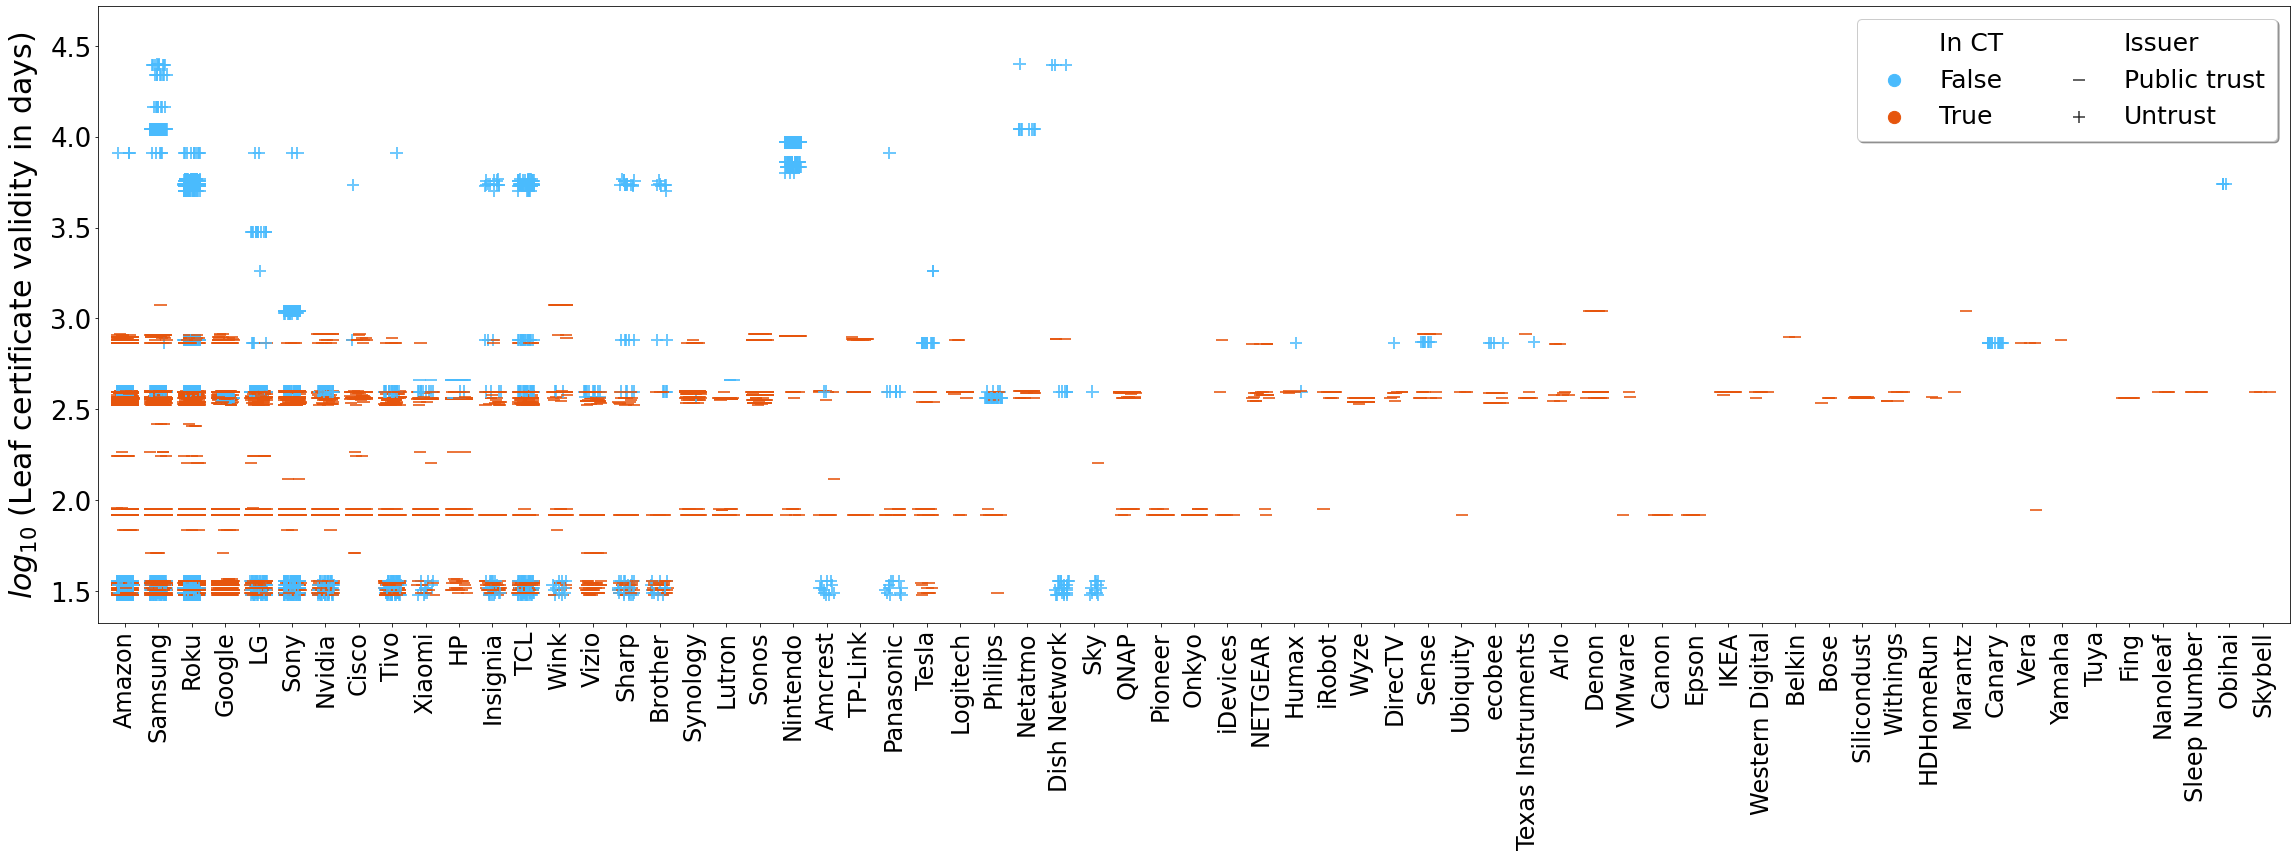

In [37]:
fig = plt.figure(figsize=(32,12))
#sns.despine(bottom=True, left=True)

#issuer_palette = ["#E6550D", "#9ECAE1"]
issuer_palette = ["#4ABBFD", "#E6550D"]
markers = {"Public trust": "_", "Untrust": "+"}

ax = sns.scatterplot(x="jittered", y="certday_log10", hue="In CT", style="Issuer", s=150, \
                   palette=issuer_palette, markers=markers, \
                   data=df_leafval_sort, alpha=.8, linewidth=2, x_jitter=True)

ax.set_xlim(0.2, 65.8)
ax.set_xlabel('')
ax.set_ylabel("$log_{10}$ (Leaf certificate validity in days)", fontsize=30, labelpad=10)

plt.yticks(fontsize=26)

#ax.spines['top'].set_color('none')
#ax.spines['right'].set_color('none')

handles, labels = ax.get_legend_handles_labels()
#ax.set_xticklabels(ax.get_xticklabels(), fontsize=14, rotation=90, ha='right', va='center',rotation_mode='anchor')
legend = ax.legend(handles=handles[0:], labels=labels[0:], title="", \
                   loc="upper right", fancybox=True, framealpha=1, shadow=True, borderpad=.5, ncol=2,\
                   fontsize=25)
legend.get_frame().set_alpha(None)
for handle in legend.legendHandles:
    handle.set_sizes([150.0])

plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,\
            26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,\
           48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65], rotation=90, fontsize=22)
ax.set_xticklabels(['Amazon', 'Samsung', 'Roku', 'Google', 'LG', \
                    'Sony', 'Nvidia', 'Cisco', 'Tivo', 'Xiaomi', \
                    'HP', 'Insignia', 'TCL', 'Wink', 'Vizio', \
                    'Sharp', 'Brother', 'Synology', 'Lutron', 'Sonos', \
                    'Nintendo', 'Amcrest', 'TP-Link', 'Panasonic', 'Tesla', \
                    'Logitech', 'Philips', 'Netatmo', 'Dish Network', \
                    'Sky', 'QNAP', 'Pioneer', 'Onkyo', \
                    'iDevices', 'NETGEAR', 'Humax', 'iRobot', \
                    'Wyze', 'DirecTV', 'Sense', \
                    'Ubiquity', 'ecobee', 'Texas Instruments', 'Arlo', \
                    'Denon', 'VMware', 'Canon', 'Epson',\
                    'IKEA', 'Western Digital', 'Belkin', 'Bose', \
                    'Silicondust', 'Withings', 'HDHomeRun', 'Marantz', 'Canary', \
                    'Vera', 'Yamaha', 'Tuya', 'Fing', 'Nanoleaf', \
                    'Sleep Number', 'Obihai', 'Skybell'], \
                    fontsize=24, rotation=90, ha='right', va='center',rotation_mode='anchor')


fig.tight_layout()
plt.show()

## Extremely long certificates

In [38]:
df_leafval_drop.loc[df_leafval_drop['cert_days'] > 1000].groupby("issuer_O")['cert_days'].agg('max').reset_index(name='max').sort_values(by='max', ascending=False)

,issuer_O,max
14,nan,36500
10,Samsung Electronics,25202
1,EchoStar,24855
13,Universal Electronics Inc,21946
9,Samsung,10950
6,Nintendo of America Inc.,9300
4,Netflix Inc,8150
5,Nintendo of America,7233
8,Roku,5854
7,Obihai Technology Inc.,5475


In [39]:
df_leafval_drop.loc[(df_leafval_drop['issuer_O'] == 'nan') & \
                    (df_leafval_drop['cert_days'] == 36500)]

,device_vendor,sni,serial_num,response,cert_days,issuer_O,issuer_CN,device_id
21428,tuya,a2.tuyaus.com,0086cd856e1ee3ae33,False,36500,nan,nan,s5404e0848a
21429,tuya,a2.tuyaus.com,0086cd856e1ee3ae33,False,36500,nan,nan,s7cb977087f
21430,tuya,a2.tuyaus.com,0086cd856e1ee3ae33,False,36500,nan,nan,sd895140d26


## Certificates not in CT

In [40]:
serial = "E84177AB21D3317EADE71FDE938A41C8".lower()

In [41]:
serial

'e84177ab21d3317eade71fde938a41c8'

In [42]:
df_leafval.loc[df_leafval['serial_num'] == serial]['sni'].value_counts() 

Series([], Name: sni, dtype: int64)

In [43]:
pd.set_option('display.max_colwidth', None)

In [44]:
df_leafval.sample(1)

,device_vendor,sni,serial_num,response,cert_days,issuer_O,issuer_CN,device_id
113024,amazon,api.amazonalexa.com,0c4d4a3ab27ba77cca58669e98eb6ce7,True,342,Amazon,Amazon,s3f2ffcb5e9


In [45]:
df_notct = df_leafval.loc[df_leafval['response'] == False]

In [46]:
df_notct.shape

(40772, 8)

In [47]:
df_notct['issuer_O'] = df_notct['issuer_O'].apply(lambda x: parse_issuer(x))

<ipython-input-47-7ef7629fb151>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_notct['issuer_O'] = df_notct['issuer_O'].apply(lambda x: parse_issuer(x))


In [48]:
tab1 = df_notct.groupby(['issuer_O'])['sni'].agg(sni_set=lambda x: set(x), sni_count=lambda x: len(set(x))).reset_index()

In [49]:
tab2 = df_notct.groupby(['issuer_O'])['device_vendor'].agg(vendor_set=lambda x: sorted(set(x))).reset_index()

In [50]:
tab3 = df_notct.groupby(['issuer_O'])['serial_num'].agg(cert_count=lambda x: len(set(x))).reset_index()

In [51]:
tab4 = df_notct.groupby(['issuer_O'])['device_id'].agg(dev_set=lambda x: set(x)).reset_index()

In [52]:
tab5 = df_notct.groupby(['issuer_O'])['device_id'].agg(devnum=lambda x: x.nunique()).reset_index()

In [53]:
tab_merge = pd.merge(tab1, tab2, how='inner', left_on=['issuer_O'], right_on=['issuer_O']).sort_values('sni_count', ascending=False)

In [54]:
tab_merge = pd.merge(tab3, tab_merge, how='inner', left_on='issuer_O', right_on='issuer_O')

In [55]:
tab_merge = pd.merge(tab4, tab_merge, how='inner', left_on='issuer_O', right_on='issuer_O')

In [56]:
tab_merge = pd.merge(tab5, tab_merge, how='inner', left_on='issuer_O', right_on='issuer_O')

In [57]:
tab_merge.sort_values('devnum', ascending=False)

,issuer_O,devnum,dev_set,cert_count,sni_set,sni_count,vendor_set
7,Netflix,280,"{s2a040f8db0, s0e143ac1fd, s178169d84a, seead2b996f, s0746560305, s72590d39b5, sd0cd9d7aa5, sed3a95a185, sd5f52d32e1, s407c86a7d6, s83ebaf5591, sff1645f919, sc3520ec27b, s52d431acac, sbe385c210e, sfd8c299d48, s568076e78a, sf878656922, s826b925b18, s2218a59e45, s0dda052cba, s13f13f54f2, s813b3720f8, s538a738b0e, sd2cad858ed, s0ab7d753f2, s2b533c6e00, sdb98aed595, s334509ed34, sa9387a7ede, s2f423e2e4b, s7c9b20cf18, s4af217743c, sd4a72a29ea, s6008f35598, s02e268892f, s57a3f263b0, s90257e1cea, s000859518c, se88a7c61cb, sb7ad336245, s8b6ccc4822, s0cfb9b11b6, s2211f1d083, s176cb823f4, s53b182dd78, s456fbd5382, s6fd82a52e0, s1772194a24, s8fd7acf70d, s115938e8d8, s9a7e9ca5bf, sc2b7834444, s879a0b4a45, s3cf230380d, sc18cb97cb1, s9843e1ffec, saf608786f0, scdd8e4ec6a, saabb2db8d8, scda19871d7, sfefab8724e, safc1350b4e, see60c5a86a, s8caf45997f, s40d6448bbb, sed4f22f874, s088a528f27, s2ac14d4d8d, s6d591581f3, sc224a5bafc, s8ee8334fff, sbafa0069e9, s1715574b8b, sfd51770f0f, sde1818f912, sc01b8fefb1, sb1d28757e1, s3edb13b126, see5125f36b, s4e406d9d6d, sa43bd7699b, seaa8d5316e, sb82fe181b1, sef6da4156a, s95ccf22f96, s24c6c1c71a, s971d6fb89a, scf5a6c0b77, s98b0054b80, s19277670e1, s2a4f8254b2, sfd57f8b395, sfcd21b3bce, s9cbc0cf387, s3fe9b67697, s5b3d58c13d, s43277f2d0a, s1b41c09abf, s7465a6cc23, ...}",16,"{appboot.netflix.com, nrdp50-appboot.netflix.com, nccp-nrdp-31.cloud.netflix.net, nrdp.nccp.netflix.com, ichnaea.netflix.com, nrdp51-appboot.netflix.com, customerevents.netflix.com, api.netflix.com, secure.netflix.com, api-global.netflix.com, uiboot.netflix.com}",11,"[amazon, amcrest, brother, dish network, hp, humax, insignia, lg, nvidia, panasonic, philips, roku, samsung, sharp, sky, sony, tcl, tivo, vizio, wink, xiaomi]"
11,Roku,134,"{s2a040f8db0, s0e143ac1fd, s178169d84a, s7ae6ab7f3b, seead2b996f, sd0cd9d7aa5, sed3a95a185, sd5f52d32e1, s407c86a7d6, s83ebaf5591, sc3520ec27b, sf878656922, s9712773c82, s13f13f54f2, s7a1f4713f2, s0ab7d753f2, s334509ed34, sd4a72a29ea, s6008f35598, s02e268892f, s10f8b80bef, s5e83062a24, s0cfb9b11b6, s2211f1d083, s7622fb49b5, sc2b7834444, s879a0b4a45, s9a7e9ca5bf, s3cf230380d, scda19871d7, see60c5a86a, safc1350b4e, s9dbeeedbb9, sc224a5bafc, s6d591581f3, s62293eac15, sbafa0069e9, sfd51770f0f, s3edb13b126, see5125f36b, sa43bd7699b, sb82fe181b1, s24c6c1c71a, s19277670e1, s7465a6cc23, s43277f2d0a, sf24a6bd8a3, sfff9327ea0, se5b5933d85, sc5b9af3a56, s2bd397eabf, s83b59a8b29, sd434a5c032, sbade24f24f, s21e27cf918, sba8d3874fc, s64ba23cdb3, sffc152f21e, s404a230fbb, sc714356f9b, sce5b924cef, s692a0a7478, s619a795537, sff73dd5bb7, s57bca9d644, s4ea505d8ef, sf6255ed86e, s337c1229f0, sb5b67a8ddc, scf97152f74, s9c1cba6e59, s721b527afe, sc58f34c6c2, s104f070df8, sb8b1a56f9a, s2b83c43a1b, s3398544194, s4bf577ba81, sfcb59bb1cc, s33fec7ad4d, s3f273880a2, sa4b89606bd, s639e45aa1d, s6f183f11b4, s9341b95931, s73b06dce8b, sdf2756a86b, s2db497817c, s8a0908acec, s587f419a9c, s17ceff62c1, s247e0067f1, s0222d29760, s366108f010, sdef8ac718f, s6c2a4f75d7, s39bd6c2ef7, sb9191a5fc8, sae648cf49a, s8d695bf07f, ...}",11,"{austin.sw.roku.com, liberty.sw.roku.com, austin.logs.roku.com, longview.sb.roku.com, giga.sw.roku.com, api.sr.roku.com, giga.logs.roku.com, tis.cti.roku.com, i.ads.roku.com, austin.sb.roku.com, amarillo.sb.roku.com, api.roku.com, bryan.sw.roku.com, scribe.logs.roku.com, cloudservices.roku.com, gilbert.sw.roku.com, configsvc.cs.roku.com, gilbert.sb.roku.com, cooper.logs.roku.com, giga.sb.roku.com, liberty.logs.roku.com, bryan.sb.roku.com, content.sr.roku.com, liberty.sb.roku.com, amarillo.sw.roku.com, sugarland.sb.roku.com, api2.sr.roku.com, cooper.sb.roku.com, api.rokutime.com, longview.sw.roku.com, sugarland.sw.roku.com}",31,"[brother, cisco, insignia, roku, sharp, tcl]"
6,Nest Labs,65,"{sc0e98160e7, s1c81554044, scec35b7b68, s7b77742bbd, s162f2f13a7, sb78e39712c, s97d7c1cc53, s91255e99ea, s30c98839cf, s01dfcefa53, s2b6bfa2612, s7ad415490c, s4

## In CT: untrust issuer

In [58]:
df_leafval_sort.sample(1)

,device_vendor,sni,serial_num,In CT,cert_days,issuer_O,issuer_CN,device_id,count,certday_log10,Issuer,vendor_id,jittered
1270,Google,tools.google.com,5fec2188d7658a640a000000013c6752,True,83,Google Trust Services,GTS CA 1C3,s68e9c7edc6,4837,1.919078,Public trust,4,4.018384


In [59]:
df_ct = df_leafval_sort.loc[(df_leafval_sort['In CT'] == True) &\
                            (df_leafval_sort['Issuer'] == "Untrust")]

In [60]:
df_ct.shape

(0, 13)

In [61]:
df_ct2 = df_leafval_sort.loc[(df_leafval_sort['In CT'] == False) &\
                            (df_leafval_sort['Issuer'] == "Public trust")]

In [62]:
df_ct2.shape

(32, 13)

## Roku

In [63]:
df_leafval_sort.loc[df_leafval_sort['sni'].str.contains("roku")].groupby(['issuer_O', 'cert_days'])['sni'].agg('count').reset_index(name='count')

,issuer_O,cert_days,count
0,Amazon,393,214
1,Amazon,394,45
2,COMODO,365,36
3,DigiCert,381,24
4,Let's Encrypt,89,10
5,Roku,760,138
6,Roku,5005,38
7,Roku,5329,66
8,Roku,5416,197
9,Roku,5469,42


## Netflix

In [64]:
df_leafval_sort.loc[(df_leafval_sort['sni'].str.contains("netflix")) | (df_leafval_sort['sni'].str.contains("nflx"))].groupby('issuer_O')['sni'].agg('count')

issuer_O
DigiCert    4031
Netflix     2114
Name: sni, dtype: int64

In [65]:
df_leafval_sort.sample(1)

,device_vendor,sni,serial_num,In CT,cert_days,issuer_O,issuer_CN,device_id,count,certday_log10,Issuer,vendor_id,jittered
2442,Google,ford.demdex.net,0894020d49ee27bd2076c337cbf99282,True,396,DigiCert,DigiCert TLS RSA SHA256 2020 CA1,s278754cc55,4837,2.597695,Public trust,4,4.000853


In [66]:
netflix = df_leafval_sort.loc[df_leafval_sort['issuer_O'].str.startswith("Netflix")]

In [67]:
netflix.shape

(2114, 13)

In [68]:
netflix1 = netflix.groupby(['In CT', 'issuer_CN'])['serial_num'].agg(cert_set=lambda x: set(x), num_cert=lambda x: len(set(x))).reset_index()

In [69]:
netflix2 = netflix.groupby(['In CT', 'issuer_CN'])['cert_days'].agg(cert_days=lambda x: set(x)).reset_index()

In [70]:
netflix3 = netflix.groupby(['In CT', 'issuer_CN'])['sni'].agg(sni_set = lambda x: set(x)).reset_index()

In [71]:
netflix_merge = pd.merge(netflix1, netflix2, left_on=['In CT', 'issuer_CN'], right_on=['In CT', 'issuer_CN'], how='inner')

In [72]:
netflix_merge = pd.merge(netflix_merge, netflix3, left_on=['In CT', 'issuer_CN'], right_on=['In CT', 'issuer_CN'], how='inner')

In [73]:
netflix_merge

,In CT,issuer_CN,cert_set,num_cert,cert_days,sni_set
0,False,Netflix Public SHA2 RSA CA 3,"{0da990551346461563aee07f8691defe, 05f305e73708715d5da07e9300952cd0, 0a3221a7ebf99d71960d31fe425ab69d, 01169f1249562ecceb486641ec1a8f45, 0cd420cc759ce8e96c3be53494dfc711, 0efe36876de5c9be6700dd194a011588, 0ab3ec48f76a43d67558d10bbf08447c, 0b205647250c3b6496039f582b124119, 055831176ef62f55a2e0af91b558b8e5, 097c73332d504b2a359ec1d27c5e033b, 099f0ff9b649373551b6168218d31749, 0c259feba33d6f31abb666e83ba20b31, 0d583a8e2d5df32d424589ec81c5e851}",13,"{32, 33, 34, 36, 396, 30, 31}","{ichnaea.netflix.com, customerevents.netflix.com, api.netflix.com, secure.netflix.com, api-global.netflix.com, uiboot.netflix.com}"
1,False,Primary Certificate Authority,"{01131c26d92130743a79219ad2292c8deed5, 019a641b97c22001a7994740b3f19a543696, 01505884ca4a937e9131068877e360301a4a}",3,{8150},"{appboot.netflix.com, nrdp50-appboot.netflix.com, nrdp.nccp.netflix.com, nccp-nrdp-31.cloud.netflix.net, nrdp51-appboot.netflix.com}"


In [74]:
netflix_serial = list(set(netflix['serial_num'].tolist()))

In [75]:
netflix_serial

['0da990551346461563aee07f8691defe',
 '05f305e73708715d5da07e9300952cd0',
 '0a3221a7ebf99d71960d31fe425ab69d',
 '01169f1249562ecceb486641ec1a8f45',
 '0cd420cc759ce8e96c3be53494dfc711',
 '0efe36876de5c9be6700dd194a011588',
 '0ab3ec48f76a43d67558d10bbf08447c',
 '0b205647250c3b6496039f582b124119',
 '01131c26d92130743a79219ad2292c8deed5',
 '019a641b97c22001a7994740b3f19a543696',
 '055831176ef62f55a2e0af91b558b8e5',
 '097c73332d504b2a359ec1d27c5e033b',
 '099f0ff9b649373551b6168218d31749',
 '0c259feba33d6f31abb666e83ba20b31',
 '01505884ca4a937e9131068877e360301a4a',
 '0d583a8e2d5df32d424589ec81c5e851']

### Find intermediate/root issuer

In [83]:
iot_ssl = pd.read_csv("../datasets/ny_zeek_sslx509.csv")

In [84]:
iot_ssl.sample(1)

,ts_x,uid,id.orig_h,id.orig_p,id.resp_h,id.resp_p,version,cipher,curve,server_name,resumed,last_alert,next_protocol,established,ssl_history,cert_chain_fps,client_cert_chain_fps,sni_matches_cert,validation_status,fingerprint,ts_y,certificate.version,certificate.serial,certificate.subject,certificate.issuer,certificate.not_valid_before,certificate.not_valid_after,certificate.key_alg,certificate.sig_alg,certificate.key_type,certificate.key_length,certificate.exponent,certificate.curve,san.dns,san.uri,san.email,san.ip,basic_constraints.ca,basic_constraints.path_len,host_cert,client_cert,issuer_O,issuer_CN,subject_CN,not_before,not_after,validity_days
3165,1.650126e+09,CfJ7Fv3Q4uYJMl0aji,67.205.150.252,53027.0,20.189.173.12,443.0,TLSv12,TLS_ECDHE_RSA_WITH_AES_256_GCM_SHA384,secp384r1,self.events.data.microsoft.com,F,-,-,T,CsxknGIi,"d7271bd50180e051fbe44389a4b7e7478dbd77bcf642c3040fa3183b059d79ed,48ff8b494668c752304b48bfe818758987def6582e5f09b921f4b60bb3d6a8dd",(empty),T,ok,d7271bd50180e051fbe44389a4b7e7478dbd77bcf642c3040fa3183b059d79ed,1.650129e+09,3.0,33002BADB5BB537A82CA847F580000002BADB5,"CN=*.events.data.microsoft.com,O=Microsoft Corporation,L=Redmond,ST=WA,C=US","CN=Microsoft Azure TLS Issuing CA 06,O=Microsoft Corporation,C=US",1.646224e+09,1.677328e+09,rsaEncryption,sha384WithRSAEncryption,rsa,2048.0,65537.0,-,"*.events.data.microsoft.com,events.data.microsoft.com,*.pipe.aria.microsoft.com,pipe.skype.com,*.pipe.skype.com,*.mobile.events.data.microsoft.com,mobile.events.data.microsoft.com,*.events.data.msn.com,events.data.msn.com,*.events.data.msn.cn,events.data.msn.cn,oca.microsoft.com,watson.microsoft.com",-,-,-,-,-,T,F,Microsoft Corporation,Microsoft Azure TLS Issuing CA 06,*.events.data.microsoft.com,"03/02/2022, 07:24:03","02/25/2023, 07:24:03",360


In [85]:
iot_ssl.shape

(6180, 47)

In [86]:
iot_x509 = pd.read_csv("../datasets/ny_zeek_x509.csv")

In [87]:
iot_x509.sample(1)

,ts,fingerprint,certificate.version,certificate.serial,certificate.subject,certificate.issuer,certificate.not_valid_before,certificate.not_valid_after,certificate.key_alg,certificate.sig_alg,certificate.key_type,certificate.key_length,certificate.exponent,certificate.curve,san.dns,san.uri,san.email,san.ip,basic_constraints.ca,basic_constraints.path_len,host_cert,client_cert
26330,1650128490.445626,d698ed3c70d91205a44ada5b698a96b13e3efdb7043175c29aaa1adcfda3cfc5,3.0,095DC1AF44CB5A23C7F64AFC3D48564A,"CN=content.dropboxapi.com,O=Dropbox\\, Inc,L=San Francisco,ST=California,C=US,serialNumber=4348296,jurisdictionST=Delaware,jurisdictionC=US,businessCategory=Private Organization","CN=DigiCert SHA2 Extended Validation Server CA,OU=www.digicert.com,O=DigiCert Inc,C=US",1.643173e+09,1.676956e+09,rsaEncryption,sha256WithRSAEncryption,rsa,2048.0,65537.0,-,"content.dropboxapi.com,content-au.dropboxapi.com,content-eu.dropboxapi.com,content-uk.dropboxapi.com,content-jp.dropboxapi.com,api-content.dropbox.com,api-content-au.dropbox.com,api-content-eu.dropbox.com,api-content-uk.dropbox.com,api-content-jp.dropbox.com,api-content1.dropbox.com,api-content1-au.dropbox.com,api-content1-eu.dropbox.com,api-content1-uk.dropbox.com,api-content1-jp.dropbox.com",-,-,-,F,-,T,F


In [88]:
netflix_cert=[]
for serial in netflix_serial:
    serial = serial.upper()
    netflix_cert.append(serial)

In [89]:
netflix_cert

['0DA990551346461563AEE07F8691DEFE',
 '05F305E73708715D5DA07E9300952CD0',
 '0A3221A7EBF99D71960D31FE425AB69D',
 '01169F1249562ECCEB486641EC1A8F45',
 '0CD420CC759CE8E96C3BE53494DFC711',
 '0EFE36876DE5C9BE6700DD194A011588',
 '0AB3EC48F76A43D67558D10BBF08447C',
 '0B205647250C3B6496039F582B124119',
 '01131C26D92130743A79219AD2292C8DEED5',
 '019A641B97C22001A7994740B3F19A543696',
 '055831176EF62F55A2E0AF91B558B8E5',
 '097C73332D504B2A359EC1D27C5E033B',
 '099F0FF9B649373551B6168218D31749',
 '0C259FEBA33D6F31ABB666E83BA20B31',
 '01505884CA4A937E9131068877E360301A4A',
 '0D583A8E2D5DF32D424589EC81C5E851']

In [90]:
iot_ssl['cert_chain_fps'] = iot_ssl['cert_chain_fps'].fillna("missing")

In [91]:
iot_ssl['fingerprint'] = iot_ssl['cert_chain_fps'].apply(lambda x: x.split(",")[0])

In [92]:
netflix_finger_lis = list(set(iot_x509.loc[iot_x509['certificate.serial'].isin(netflix_cert)]['fingerprint'].tolist()))

In [93]:
netflix_ssl = iot_ssl.loc[iot_ssl['fingerprint'].isin(netflix_finger_lis)]

In [94]:
netflix_ssl.shape

(148, 47)

In [95]:
netflix_ssl['cert_chain_len'] = netflix_ssl['cert_chain_fps'].apply(lambda x: len(x.split(",")))

<ipython-input-95-a9ed37d8f59b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  netflix_ssl['cert_chain_len'] = netflix_ssl['cert_chain_fps'].apply(lambda x: len(x.split(",")))


In [96]:
netflix_ssl['cert_chain_len'].value_counts().nlargest(10)

2    148
Name: cert_chain_len, dtype: int64

In [97]:
netflix_ssl.sample(3)

,ts_x,uid,id.orig_h,id.orig_p,id.resp_h,id.resp_p,version,cipher,curve,server_name,resumed,last_alert,next_protocol,established,ssl_history,cert_chain_fps,client_cert_chain_fps,sni_matches_cert,validation_status,fingerprint,ts_y,certificate.version,certificate.serial,certificate.subject,certificate.issuer,certificate.not_valid_before,certificate.not_valid_after,certificate.key_alg,certificate.sig_alg,certificate.key_type,certificate.key_length,certificate.exponent,certificate.curve,san.dns,san.uri,san.email,san.ip,basic_constraints.ca,basic_constraints.path_len,host_cert,client_cert,issuer_O,issuer_CN,subject_CN,not_before,not_after,validity_days,cert_chain_len
3897,1.650123e+09,C931S34j728sSp998i,67.205.150.252,51099.0,34.236.220.111,443.0,TLSv12,TLS_ECDHE_RSA_WITH_AES_128_GCM_SHA256,secp256r1,api.netflix.com,F,-,-,T,CsxknGIi,"2a21c63433968c5e7d0e4b2486a2010c2e39079a93bf6b3dbf6da68e2d2df4ba,8cb67e8e76de03a83b9a4daaea595f70850df42a6e5602444754fc52f4001633",(empty),T,unable to get local issuer certificate,2a21c63433968c5e7d0e4b2486a2010c2e39079a93bf6b3dbf6da68e2d2df4ba,1.650130e+09,3.0,05F305E73708715D5DA07E9300952CD0,"CN=api.netflix.com,O=Netflix\\, Inc.,L=Los Gatos,ST=California,C=US","CN=Netflix Public SHA2 RSA CA 3,O=Netflix\\, Inc.,C=US",1.638162e+09,1.672463e+09,rsaEncryption,sha256WithRSAEncryption,rsa,2048.0,65537.0,-,"api-latam.netflix.com,htmltvui.netflix.com,api-eu.netflix.com,uiboot.netflix.com,api-global.netflix.com,api-user.netflix.com,api-us.netflix.com,api.netflix.com,api-global-prefix.netflix.com",-,-,-,F,-,T,F,Netflix\\,Netflix Public SHA2 RSA CA 3,api.netflix.com,"11/29/2021, 00:00:00","12/30/2022, 23:59:59",396,2
3877,1.650131e+09,COTnT0158Lked9dUB2,67.205.150.252,45592.0,52.22.199.217,443.0,TLSv12,TLS_ECDHE_RSA_WITH_AES_128_GCM_SHA256,secp256r1,uiboot.netflix.com,F,-,-,T,CsxknGIi,"2a21c63433968c5e7d0e4b2486a2010c2e39079a93bf6b3dbf6da68e2d2df4ba,8cb67e8e76de03a83b9a4daaea595f70850df42a6e5602444754fc52f4001633",(empty),T,unable to get local issuer certificate,2a21c63433968c5e7d0e4b2486a2010c2e39079a93bf6b3dbf6da68e2d2df4ba,1.650130e+09,3.0,05F305E73708715D5DA07E9300952CD0,"CN=api.netflix.com,O=Netflix\\, Inc.,L=Los Gatos,ST=California,C=US","CN=Netflix Public SHA2 RSA CA 3,O=Netflix\\, Inc.,C=US",1.638162e+09,1.672463e+09,rsaEncryption,sha256WithRSAEncryption,rsa,2048.0,65537.0,-,"api-latam.netflix.com,htmltvui.netflix.com,api-eu.netflix.com,uiboot.netflix.com,api-global.netflix.com,api-user.netflix.com,api-us.netflix.com,api.netflix.com,api-global-prefix.netflix.com",-,-,-,F,-,T,F,Netflix\\,Netflix Public SHA2 RSA CA 3,api.netflix.com,"11/29/2021, 00:00:00","12/30/2022, 23:59:59",396,2
3905,1.650126e+09,Cgmf6L29eunGO3SH53,67.205.150.252,47347.0,52.0.209.138,443.0,TLSv12,TLS_ECDHE_RSA_WITH_AES_128_GCM_SHA256,secp256r1,api.netflix.com,F,-,-,T,CsxknGIi,"2a21c63433968c5e7d0e4b2486a2010c2e39079a93bf6b3dbf6da68e2d2df4ba,8cb67e8e76de03a83b9a4daaea595f70850df42a6e5602444754fc52f4001633",(empty),T,unable to get local issuer certificate,2a21c63433968c5e7d0e4b2486a2010c2e39079a93bf6b3dbf6da68e2d2df4ba,1.650130e+09,3.0,05F305E73708715D5DA07E9300952CD0,"CN=api.netflix.com,O=Netflix\\, Inc.,L=Los Gatos,ST=California,C=US","CN=Netflix Public SHA2 RSA CA 3,O=Netflix\\, Inc.,C=US",1.638162e+09,1.672463e+09,rsaEncryption,sha256WithRSAEncryption,rsa,2048.0,65537.0,-,"api-latam.netflix.com,htmltvui.netflix.com,api-eu.netflix.com,uiboot.netflix.com,api-global.netflix.com,api-user.netflix.com,api-us.netflix.com,api.netflix.com,api-global-prefix.netflix.com",-,-,-,F,-,T,F,Netflix\\,Netflix Public SHA2 RSA CA 3,api.netflix.com,"11/29/2021, 00:00:00","12/30/2022, 23:59:59",396,2


In [98]:
netflix_ssl['last_cert_fingerprint'] = netflix_ssl['cert_chain_fps'].apply(lambda x: x.split(",")[-1])

<ipython-input-98-37e9788632dd>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  netflix_ssl['last_cert_fingerprint'] = netflix_ssl['cert_chain_fps'].apply(lambda x: x.split(",")[-1])


In [99]:
iot_x509_dropdup = iot_x509.drop_duplicates(['fingerprint'])

In [100]:
iot_x509_dropdup.shape

(21910, 22)

In [101]:
root_netflixssl = pd.merge(netflix_ssl, iot_x509_dropdup, left_on="last_cert_fingerprint", right_on= "fingerprint", how="left")

In [102]:
root_netflixssl.shape

(148, 71)

### Other untrust issuers signing short certificates?

In [103]:
df_leafval_sort.loc[(df_leafval_sort['cert_days']<50) & \
                    (df_leafval_sort['Issuer'] == "Untrust") & \
                    (df_leafval_sort['issuer_O'] != "Netflix")]

,device_vendor,sni,serial_num,In CT,cert_days,issuer_O,issuer_CN,device_id,count,certday_log10,Issuer,vendor_id,jittered


### Checking back with Netflix

In [104]:
netflix_df = dev_dropcol.loc[dev_dropcol['issuer_O'].str.startswith("Netflix")][['server_name_indication', 'issuer_O', 'issuer_CN', 'serial_num',\
                                                                                 'chain_issuer_O', 'chain_issuer_CN', \
                                                                                 'chain_subject_O', 'chain_subject_CN', 'cert_chain_len', 'chain_serial_from_x509af', \
                                                                                 'response', 'cert_days', 'device_vendor']]

In [105]:
netflix_df.shape

(13902, 13)

In [107]:
netflix_df = netflix_df.drop_duplicates(['server_name_indication', 'issuer_CN', 'issuer_O', 'serial_num', 'cert_chain_len'])

In [108]:
netflix_df.shape

(21, 13)

In [109]:
netflix_df['last_cert_issuer_O'] = netflix_df['chain_issuer_O'].apply(lambda x: x[-1])

<ipython-input-109-8a1aa4888a29>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  netflix_df['last_cert_issuer_O'] = netflix_df['chain_issuer_O'].apply(lambda x: x[-1])


In [110]:
netflix_df

,server_name_indication,issuer_O,issuer_CN,serial_num,chain_issuer_O,chain_issuer_CN,chain_subject_O,chain_subject_CN,cert_chain_len,chain_serial_from_x509af,response,cert_days,device_vendor,last_cert_issuer_O
91,ichnaea.netflix.com,Netflix,Netflix Public SHA2 RSA CA 3,0a3221a7ebf99d71960d31fe425ab69d,"[Netflix, VeriSign]","[Netflix Public SHA2 RSA CA 3, VeriSign Class 3 Public Primary Certification ]","[Netflix, Netflix]","[customerevents.netflix.com, Netflix Public SHA2 RSA CA 3]",2,"[0a3221a7ebf99d71960d31fe425ab69d, 35935b1ee9b4608968cd82922571a20b]",False,396,amazon,VeriSign
1884,uiboot.netflix.com,Netflix,Netflix Public SHA2 RSA CA 3,05f305e73708715d5da07e9300952cd0,"[Netflix, VeriSign]","[Netflix Public SHA2 RSA CA 3, VeriSign Class 3 Public Primary Certification ]","[Netflix, Netflix]","[api.netflix.com, Netflix Public SHA2 RSA CA 3]",2,"[05f305e73708715d5da07e9300952cd0, 35935b1ee9b4608968cd82922571a20b]",False,396,amazon,VeriSign
3790,api.netflix.com,Netflix,Netflix Public SHA2 RSA CA 3,05f305e73708715d5da07e9300952cd0,"[Netflix, VeriSign]","[Netflix Public SHA2 RSA CA 3, VeriSign Class 3 Public Primary Certification ]","[Netflix, Netflix]","[api.netflix.com, Netflix Public SHA2 RSA CA 3]",2,"[05f305e73708715d5da07e9300952cd0, 35935b1ee9b4608968cd82922571a20b]",False,396,roku,VeriSign
4544,nrdp50-appboot.netflix.com,Netflix Inc,Primary Certificate Authority,01131c26d92130743a79219ad2292c8deed5,"[Netflix Inc, Netflix Inc]","[Primary Certificate Authority, Primary Certificate Authority]","[Netflix, Netflix Inc]","[*.netflix.com, Primary Certificate Authority]",2,"[01131c26d92130743a79219ad2292c8deed5, 00]",False,8150,samsung,Netflix Inc
6496,nccp-nrdp-31.cloud.netflix.net,Netflix Inc,Primary Certificate Authority,019a641b97c22001a7994740b3f19a543696,"[Netflix Inc, Netflix Inc]","[Primary Certificate Authority, Primary Certificate Authority]","[Netflix, Netflix Inc]","[*.cloud.netflix.net, Primary Certificate Authority]",2,"[019a641b97c22001a7994740b3f19a543696, 00]",False,8150,roku,Netflix Inc
8474,customerevents.netflix.com,Netflix,Netflix Public SHA2 RSA CA 3,0a3221a7ebf99d71960d31fe425ab69d,"[Netflix, VeriSign]","[Netflix Public SHA2 RSA CA 3, VeriSign Class 3 Public Primary Certification ]","[Netflix, Netflix]","[customerevents.netflix.com, Netflix Public SHA2 RSA CA 3]",2,"[0a3221a7ebf99d71960d31fe425ab69d, 35935b1ee9b4608968cd82922571a20b]",False,396,roku,VeriSign
8523,nrdp51-appboot.netflix.com,Netflix Inc,Primary Certificate Authority,01131c26d92130743a79219ad2292c8deed5,"[Netflix Inc, Netflix Inc]","[Primary Certificate Authority, Primary Certificate Authority]","[Netflix, Netflix Inc]","[*.netflix.com, Primary Certificate Authority]",2,"[01131c26d92130743a79219ad2292c8deed5, 00]",False,8150,amazon,Netflix Inc
8673,secure.netflix.com,Netflix,Netflix Public SHA2 RSA CA 3,0c259feba33d6f31abb666e83ba20b31,"[Netflix, VeriSign]","[Netflix Public SHA2 RSA CA 3, VeriSign Class 3 Public Primary Certification ]","[Netflix, Netflix]","[secure.netflix.com, Netflix Public SHA2 RSA CA 3]",2,"[0c259feba33d6f31abb666e83ba20b31, 35935b1ee9b4608968cd82922571a20b]",False,31,amazon,VeriSign
12779,appboot.netflix.com,Netflix Inc,Primary Certificate Authority,01131c26d92130743a79219ad2292c8deed5,"[Netflix Inc, Netflix Inc]","[Primary Certificate Authority, Primary Certificate Authority]","[Netflix, Netflix Inc]","[*.netflix.com, Primary Certificate Authority]",2,"[01131c26d92130743a79219ad2292c8deed5, 00]",False,8150,amazon,Netflix Inc
14282,secure.netflix.com,Netflix,Netflix Public SHA2 RSA CA 3,01169f1249562ecceb486641ec1a8f45,"[Netflix, VeriSign]","[Netflix Public SHA2 RSA CA 3, VeriSign Class 3 Public Primary Certification ]","[Netflix, Netflix]","[secure.netflix.com, Netflix Public SHA2 RSA CA 3]",2,"[01169f1249562ecceb486641ec1a8f45, 35935b1ee9b4608968cd82922571a20b]",False,30,amazon,VeriSign


In [112]:
netflix_df.groupby(['issuer_O', 'issuer_CN', 'last_cert_issuer_O', 'response'])['cert_days'].agg(cert_day_set=lambda x: set(x)).reset_index()

,issuer_O,issuer_CN,last_cert_issuer_O,response,cert_day_set
0,Netflix,Netflix Public SHA2 RSA CA 3,VeriSign,False,"{32, 33, 34, 36, 396, 30, 31}"
1,Netflix Inc,Primary Certificate Authority,Netflix Inc,False,{8150}
